## Hybird Search RAG

In [2]:
# Import required libraries for hybrid search RAG system
from langchain_groq import ChatGroq
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# Hybrid search components: combines dense (vector) and sparse (BM25) retrieval
from langchain_community.retrievers import PineconeHybridSearchRetriever
from pinecone import Pinecone, ServerlessSpec
from pinecone_text.sparse import BM25Encoder

# Load environment variables from .env file
from dotenv import load_dotenv
_ = load_dotenv()

In [3]:
# Initialize core components for the hybrid RAG system
llm = ChatGroq(model="openai/gpt-oss-120b") 
embedding_model = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")
bm25_encoder = BM25Encoder().default()  # BM25 encoder for keyword-based sparse search

In [4]:
# Test the embedding model to verify it works and check embedding dimension
vectors = embedding_model.embed_query("Hello World")
len(vectors)  # Display the dimension of the embeddings

3072

In [5]:
# Initialize Pinecone and create the index for hybrid search
pc = Pinecone()
index_name = "hybrid-search-rag"

# Create the index if it doesn't already exist
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=3072,  # Dimension matches Gemini embeddings (3072)
        metric="dotproduct",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1",
        )
    )

In [6]:
# Get reference to the Pinecone index
index = pc.Index(index_name)
index  # Display index information

In [7]:
import os

# Function to load PDF documents from a specified directory
def load_documents(data_dir):
    documents = []
    for file in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file)
        # Load PDF files using PyPDFLoader
        if file.endswith(".pdf"):
            loader = PyPDFLoader(file_path)
            documents.extend(loader.load())
        # Optional: Support for DOCX files (commented out)
        # elif file.endswith(".docx"):
        #     loader = Docx2txtLoader(file_path)
        #     documents.extend(loader.load())
    return documents

In [8]:
# Load all PDF documents from the data directory
docs = load_documents("data")
len(docs)  # Display number of documents loaded

3

In [9]:
# Split documents into chunks for better retrieval and processing
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,      
    chunk_overlap=200   
)
chunks = splitter.split_documents(docs)
len(chunks)  # Display total number of chunks created

15

In [10]:
# Extract text content from chunks for BM25 encoding
chunks_text = [chunk.page_content for chunk in chunks]

In [11]:
# Display the total number of text chunks
len(chunks_text)

15

In [12]:
# Train BM25 encoder on the document chunks and persist the values
# This enables keyword-based (sparse) search capabilities

# Fit TF-IDF values on the documents
bm25_encoder.fit(chunks_text)

# Store the BM25 values to a JSON file for later reuse
bm25_encoder.dump("bm25_values.json")

# Reload the BM25Encoder object with the saved values
bm25_encoder = BM25Encoder().load("bm25_values.json")

100%|██████████| 15/15 [00:00<00:00, 41.89it/s]



In [13]:
# Create a hybrid search retriever combining dense and sparse search
retriver = PineconeHybridSearchRetriever(
    embeddings=embedding_model,      # Dense embeddings for semantic search
    sparse_encoder=bm25_encoder,     # Sparse encoder for keyword search
    index=index,                     # Pinecone index
    top_k=3,                         # Return top 3 most relevant documents
)

In [14]:
# Add all document chunks to the Pinecone index with their metadata
retriver.add_texts(
    texts=[chunk.page_content for chunk in chunks],      
    metadatas=[chunk.metadata for chunk in chunks],    
)

100%|██████████| 1/1 [00:24<00:00, 24.75s/it]


In [15]:
results = retriver.invoke("RAG")

In [16]:
# Display the number of retrieved results
len(results)

3

## LangGraph Agent

In [17]:
# Import required libraries for building the agentic workflow
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage

from typing import Annotated, TypedDict  # Type hints for state management

In [18]:
# Define the hybrid search tool that the agent can use
@tool
def hybridSearchTool(query: str) -> dict:
    """
    Retrieve relevant information from the pdf document using hybrid search.
    Combines semantic (dense) and keyword-based (sparse) search for comprehensive retrieval.
    Use this tool when the user asks factual or conceptual questions
    that might be answered from the stored documents.
    
    Args:
        query (str): The user's question or search term
        
    Returns:
        dict: Contains the query, retrieved context, and document metadata
    """
    # Invoke the hybrid retriever to get relevant documents
    result = retriver.invoke(query)
    
    # Extract text content and metadata from retrieved documents
    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]
    
    return {
        "query": query,
        "context": context,
        "metadata": metadata,
    }

In [19]:
# Bind the tools to the LLM so it can call them during generation
tools = [hybridSearchTool]
llm_with_tools = llm.bind_tools(tools)

In [20]:
# Define the state structure for the chatbot workflow
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [21]:
# Define the main chat node that processes messages and generates responses
def chatNode(state: ChatState):
    """
    Process the current messages and generate an LLM response.
    
    Args:
        state (ChatState): The current conversation state
        
    Returns:
        dict: Updated state with the new LLM response
    """
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {
        "messages": [response]
    }

In [22]:
# Create a tool node that executes the hybrid search tool when the LLM requests it
toolNode = ToolNode(tools)

In [23]:
# Build the agentic workflow graph
graph = StateGraph(ChatState)

# Add nodes for different components of the workflow
graph.add_node("chat_node", chatNode)
graph.add_node("tools", toolNode)  

# Set up the workflow flow
graph.add_edge(START, "chat_node") 
graph.add_conditional_edges("chat_node", tools_condition)
graph.add_edge("tools", "chat_node")                 

# Compile the graph into a runnable chatbot
chatbot = graph.compile()

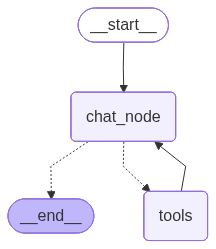

In [24]:
# Display a visual representation of the compiled chatbot workflow
chatbot

In [25]:
# Create a system message to guide the agent's behavior
system_msg = SystemMessage(
    content="You are a concise assistant. Always base answers on the provided PDF and clearly cite any document excerpts used."
)

In [27]:
# Execute the chatbot with a sample query using the hybrid search capability
# The chatbot will:
# 1. Receive the system message and user query
# 2. Decide whether to use hybridSearchTool for document retrieval
# 3. Generate a response based on retrieved context from both semantic and keyword search
result = chatbot.invoke(
    {
        "messages": [
            system_msg,
            HumanMessage(content="Explain the key components of Agent Architectue?")
        ]
    }
)

# Extract and display the final response from the chatbot
r = result['messages'][-1].content
from IPython.display import Markdown, display
display(Markdown(r))

**Key components of an AI Agent’s architecture**

| Component | What it does |
|-----------|--------------|
| **Planning module** | Breaks a high‑level goal into a sequence of manageable subtasks and decides the order in which they should be executed. |
| **Tool‑use interface** | Connects the agent to external resources (APIs, databases, calculators, etc.) so it can retrieve data, perform computations, or trigger actions outside the language model itself. |
| **Memory systems** | Stores observations, intermediate results, and past interactions, allowing the agent to retain context across steps and avoid repeating work. |
| **Reasoning‑action loop** *(overall flow)* | The agent repeatedly: receives an observation or task → reasons (using the planning module and memory) → selects and executes an action (via tool use) → observes the outcome → updates memory, looping until the goal is met. |

These elements together enable agents to move beyond single‑turn Q&A, handling multi‑step problems, dynamic environments, and real‑world tool integration.  

*Source: “Agent Architecture” section of the provided PDF, which lists Planning Module, Tool Use, and Memory Systems as the key components of AI agents.*